### 1. mse loss

In [ ]:
import cv2
import numpy as np
import os
import yaml

def mse(imageA, imageB):
    # 均方误差计算
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def calculate_average_mse(directory, reference_directory):
    total_error = 0
    video_count = 0

    # 遍历文件夹中的视频
    for filename in os.listdir(directory):
        if filename.endswith(".mp4"):
            video_path = os.path.join(directory, filename)
            reference_video_path = os.path.join(reference_directory, filename)

            # 读取视频和参考视频
            video = cv2.VideoCapture(video_path)
            reference_video = cv2.VideoCapture(reference_video_path)

            while True:
                ret, frame = video.read()
                ret_ref, reference_frame = reference_video.read()

                if not ret or not ret_ref:
                    break

                # 计算MSE
                error = mse(reference_frame, frame)
                total_error += error
                video_count += 1
            print(video_count, filename)

            video.release()
            reference_video.release()

    # 计算平均MSE
    average_error = total_error / video_count

    return average_error

def calculate_mse_for_all_subfolders(parent_directory, reference_directory):
    mse_dict = {}

    # 遍历总文件夹下的所有子文件夹
    for subfolder in os.listdir(parent_directory):
        subfolder_path = os.path.join(parent_directory, subfolder)
        if os.path.isdir(subfolder_path):
            # 计算子文件夹的平均MSE
            average_mse = calculate_average_mse(subfolder_path, reference_directory)
            mse_dict[subfolder] = average_mse

    # 保存到yaml文件
    return mse_dict

# # 使用示例
# mse_dict = calculate_mse_for_all_subfolders("/path/to/parent/directory", "/path/to/reference/directory")

# with open('config.yaml', 'w') as file:
#     yaml.dump(mse_dict, file)

In [ ]:
mse_attn_fp16 = calculate_average_mse("/home/fangtongcheng/quant_dit/diffuser-dev/logs/final_test/inference/w6a6_opensora/group/attn", 
                                        "/home/fangtongcheng/quant_dit/diffuser-dev/logs/plus/inference/fp16/generated_videos")
mse_attn_fp16  

In [ ]:
mse_cross_attn_fp16 = calculate_average_mse("/home/fangtongcheng/quant_dit/diffuser-dev/logs/final_test/inference/w6a6_opensora/group/mlp", 
                                        "/home/fangtongcheng/quant_dit/diffuser-dev/logs/plus/inference/fp16/generated_videos")
mse_cross_attn_fp16

### 2. group wise metric decoupled

In [ ]:
import os
import re
import matplotlib.pyplot as plt

# 定义总文件夹路径
parent_folder = "/home/fangtongcheng/quant_dit/diffuser-dev/logs/final_test/inference/w6a6_opensora/t_20/14_10/group"

# 正则表达式用于匹配日志文件中的数值
pattern = re.compile(r"Matched (clip_temp|clip|vqa_a|vqa_t|flow): ([0-9.]+)")

# 存储提取的数据
metrics_data = {
    'clip_temp': [],
    'clip': [],
    'vqa_a': [],
    'vqa_t': [],
    'flow': []
}

# 存储文件夹名
folder_names = []

# 遍历文件夹并读取日志文件
for subdir in sorted(os.listdir(parent_folder)):
    subfolder_path = os.path.join(parent_folder, subdir)
    if os.path.isdir(subfolder_path):
        folder_names.append(subdir)  # 添加文件夹名
        with open(os.path.join(subfolder_path, 'metrics.log'), 'r') as file:
            for line in file:
                match = pattern.search(line)
                if match:
                    key, value = match.groups()
                    metrics_data[key].append(float(value))

# 创建一个图形窗口，其中包含5个子图
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))

# 画每一条曲线在各自的子图中
for i, (key, values) in enumerate(metrics_data.items()):
    axs[i].plot(folder_names, values, label=key)
    axs[i].set_title(f'Metrics Curve for {key.capitalize()}')
    axs[i].set_xlabel('Group Name')
    axs[i].set_ylabel(key.capitalize())
    axs[i].legend()
    axs[i].grid()

# 调整子图间距
plt.tight_layout()
plt.show()

### 3. mixed precision config

In [ ]:
import yaml

# 读取模型层名字
with open('/home/fangtongcheng/quant_dit/diffuser-dev/layer_names.txt', 'r') as f:
    layers = f.read().splitlines()

# 创建字典
# dict_ranges = ['19-15', '14-10', '9-5', '4-0']
# dict_values = {layer: 8 for layer in layers}
# dict_final = {range_key: dict_values for range_key in dict_ranges}
dict_ranges = ['19-15', '14-10', '9-5', '4-0']
dict_values_19_15 = {layer: 8 for layer in layers}
dict_values_14_10 = {layer: 4 for layer in layers}
dict_values_9_5 = {layer: 2 for layer in layers}
dict_values_4_0 = {layer: 1 for layer in layers}

dict_final = {}

dict_final['19-15'] = dict_values_19_15
dict_final['14-10'] = dict_values_14_10
dict_final['9-5'] = dict_values_9_5
dict_final['4-0'] = dict_values_4_0
# for key_t in dict_ranges:
#     if key_t == '19-15':
#         dict_final[key_t] = dict_values_19_15
#     else:
#         dict_final[key_t] = dict_values_others

# 保存为yaml文件
with open('/home/fangtongcheng/quant_dit/diffuser-dev/qdiff/analysis_tools/mixed_precision/mixed_precision_config/weight_config/stdit_weight_uniform_8.yaml', 'w') as f:
    yaml.dump(dict_final, f, default_flow_style=False)


### 4. 时间步混合精度量化

In [ ]:
def get_key_for_value(dict_ranges, value):
    for key in dict_ranges:
        range_start, range_end = map(int, key.split('-'))
        if range_start >= value >= range_end:
            return key
    return None

# 创建字典
# dict_ranges = {'19-15': 'value1', '14-10': 'value2', '9-5': 'value3', '4-0': 'value4'}

with open('/home/fangtongcheng/quant_dit/diffuser-dev/qdiff/analysis_tools/mixed_precision/mixed_precision_config/weight_config/t20_4_weight_uniform_8.yaml', 'r') as f:
    time_mp_config = yaml.safe_load(f)

# 测试函数
value = 15
key = get_key_for_value(time_mp_config, value)
if key:
    print(f'值 {value} 在范围 {key} 内，对应的键值是 {type(time_mp_config[key])}')
else:
    print(f'值 {value} 不在任何范围内')


### 5. 敏感度字典构建

In [ ]:
import os
import yaml
import re
import json

# 初始化字典
result_dict = {}

# 遍历bit文件夹
for sub_folder in ['4_0', '9_5', '14_10', '19_15']:
    for bit_folder in ['bit_4', 'bit_6', 'bit_8']:
    # 遍历子文件夹
        # 如果这个键还不存在，就新建一个字典
        if sub_folder not in result_dict:
            result_dict[sub_folder] = {}
        # 遍历block文件夹
        for block_folder in [f'block_{i}' for i in range(28)]:
            print(block_folder)
            # 构造文件路径
            file_path = f'/home/fangtongcheng/quant_dit/diffuser-dev/logs/final_test/inference/block_group_quant/cross_attn_weight_opensora/{bit_folder}/t_20/{sub_folder}/{block_folder}/metrics.log'
            # 如果文件存在
            if os.path.exists(file_path):
                # 读取文件内容
                with open(file_path, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        if '\'vqa_a\'' in line:
                            d = json.loads(line.replace("'", "\""))
                            print(type(d), '\n')
                            # s = line.split(': ')[1].strip()
                            # match = re.search(r'\d+\.\d+', s)
                            # if match:

                            clip_value = float(d['clip'])
                            # 如果这个键还不存在，就新建一个列表
                            j = int(block_folder.replace('block_', ''))
                            if j < 10:
                                layer_name = f'model.blocks.0{j}.cross_attn'
                            else:
                                layer_name = f'model.blocks.{j}.cross_attn'
                            if layer_name not in result_dict[sub_folder]:
                                result_dict[sub_folder][layer_name] = []
                            # 添加clip值到列表
                            result_dict[sub_folder][layer_name].append(clip_value)
                            break
# 将结果保存为yaml文件
with open('cross_attn_weight_clip.yaml', 'w') as f:
    yaml.dump(result_dict, f)


### 5. 敏感度曲线绘制

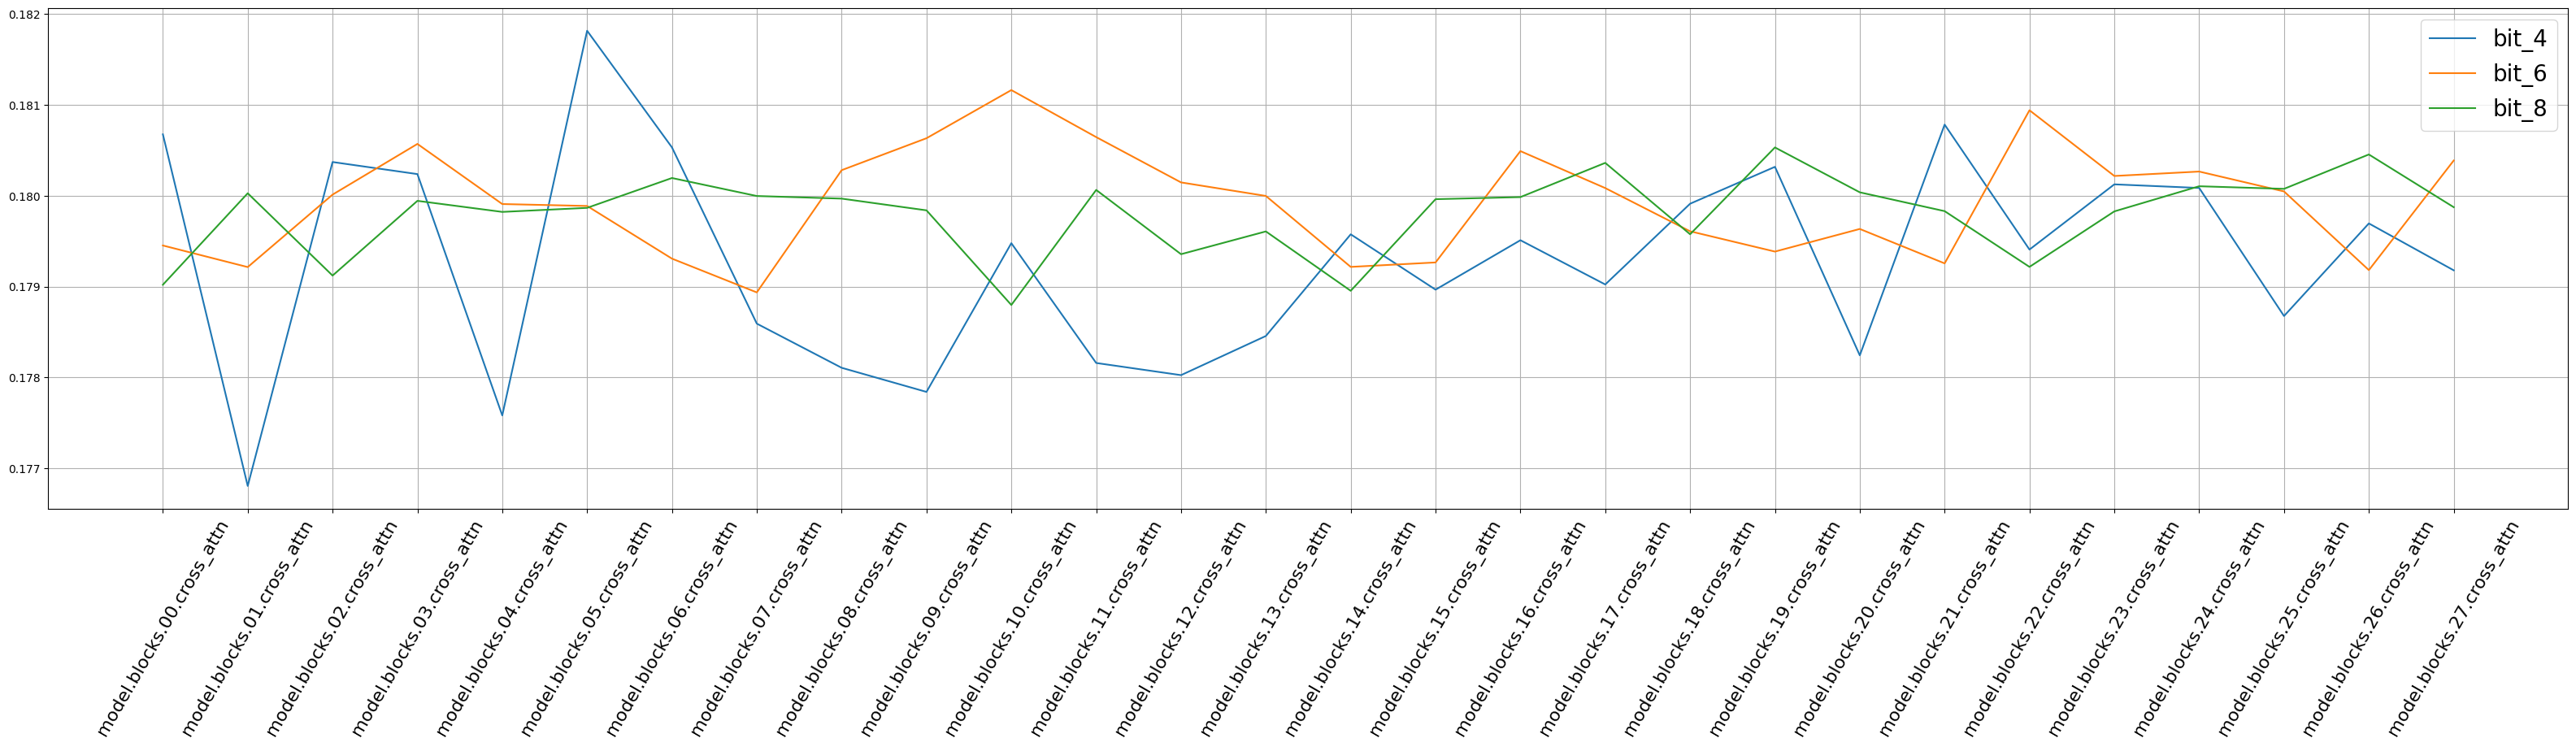

In [49]:
import matplotlib.pyplot as plt
import yaml

# 从yaml文件中加载数据
with open('/home/fangtongcheng/quant_dit/diffuser-dev/qdiff/analysis_tools/mixed_precision/sensitivity/clip/act/cross_attn_act_clip.yaml', 'r') as f:
    data = yaml.safe_load(f)

key_data = data.keys()

# 创建一个新的图形
plt.figure(figsize=(40, 8))

# 提取所有的block名称
blocks = list(data['14_10'].keys())

# 对于每个bit值，绘制一条曲线
for bit_index, bit_name in enumerate(['bit_4', 'bit_6', 'bit_8']):
    # 提取出这个bit值对应的所有数值
    values = [data['19_15'][block][bit_index] for block in blocks]
    # 绘制曲线
    plt.plot(blocks, values, label=bit_name)


# 添加图例
plt.legend(fontsize=20)
plt.xticks(rotation=60, fontsize=16)
plt.grid()
# 显示图形
plt.show()



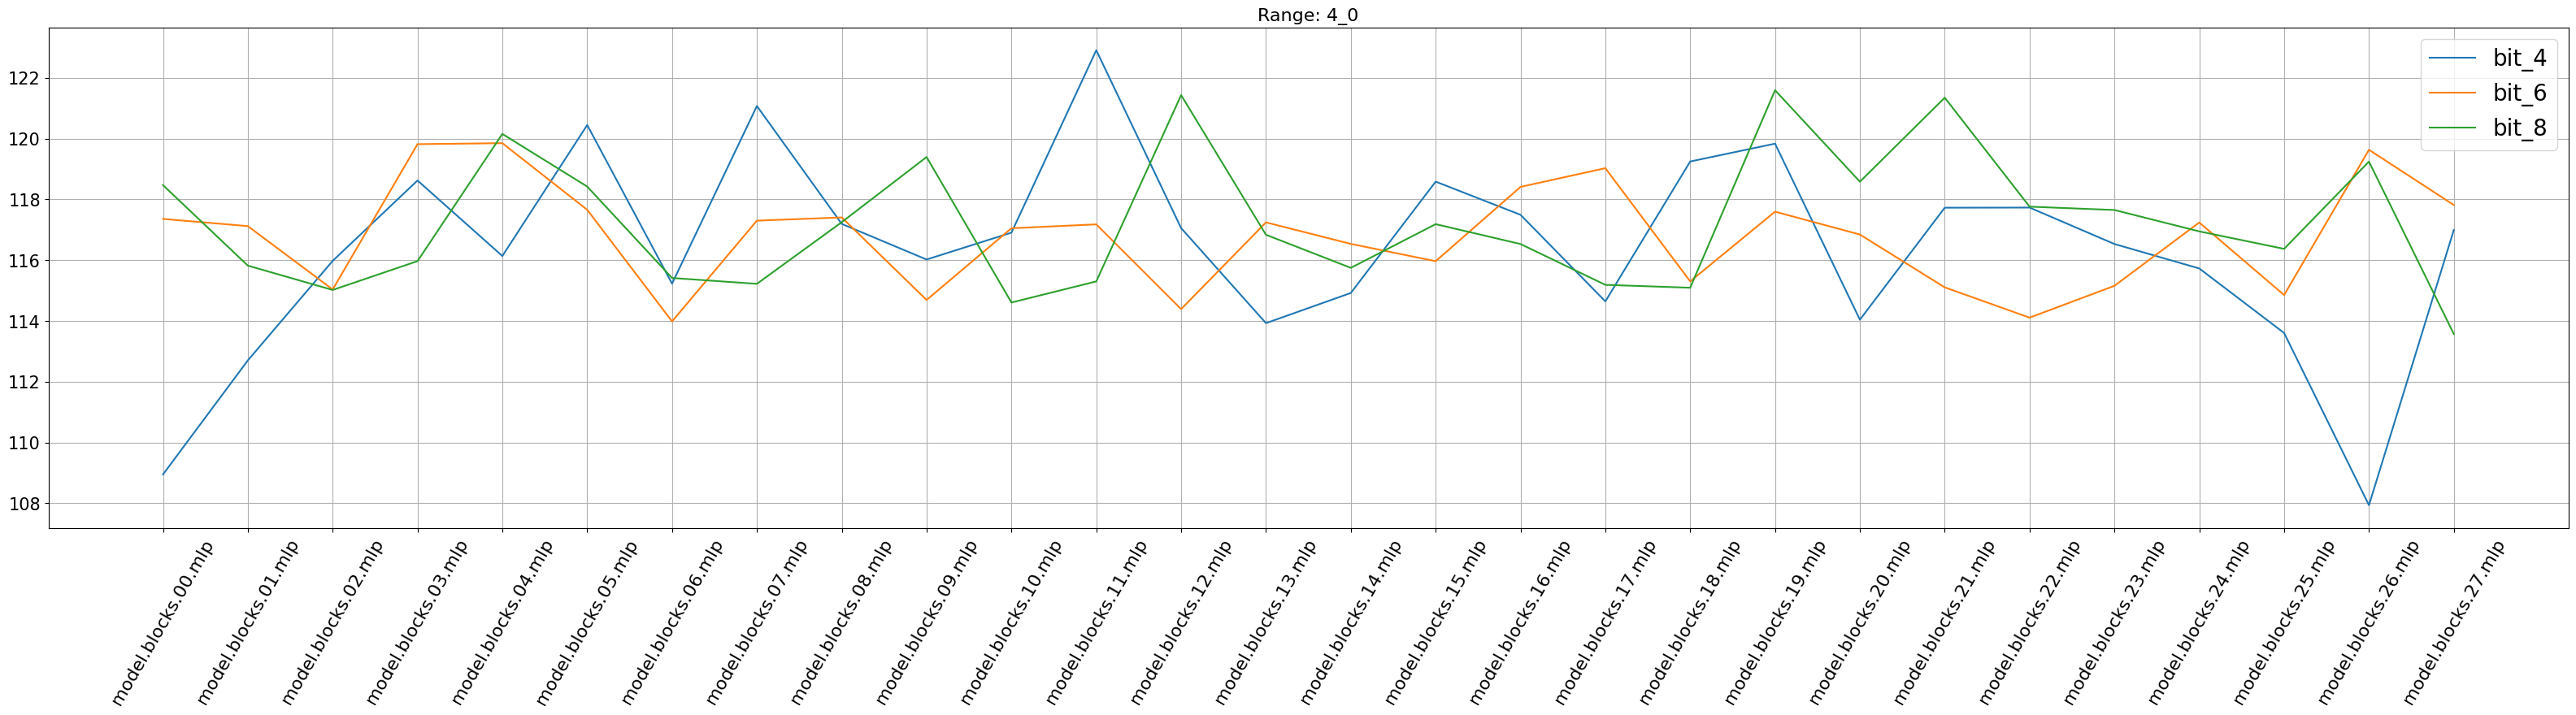

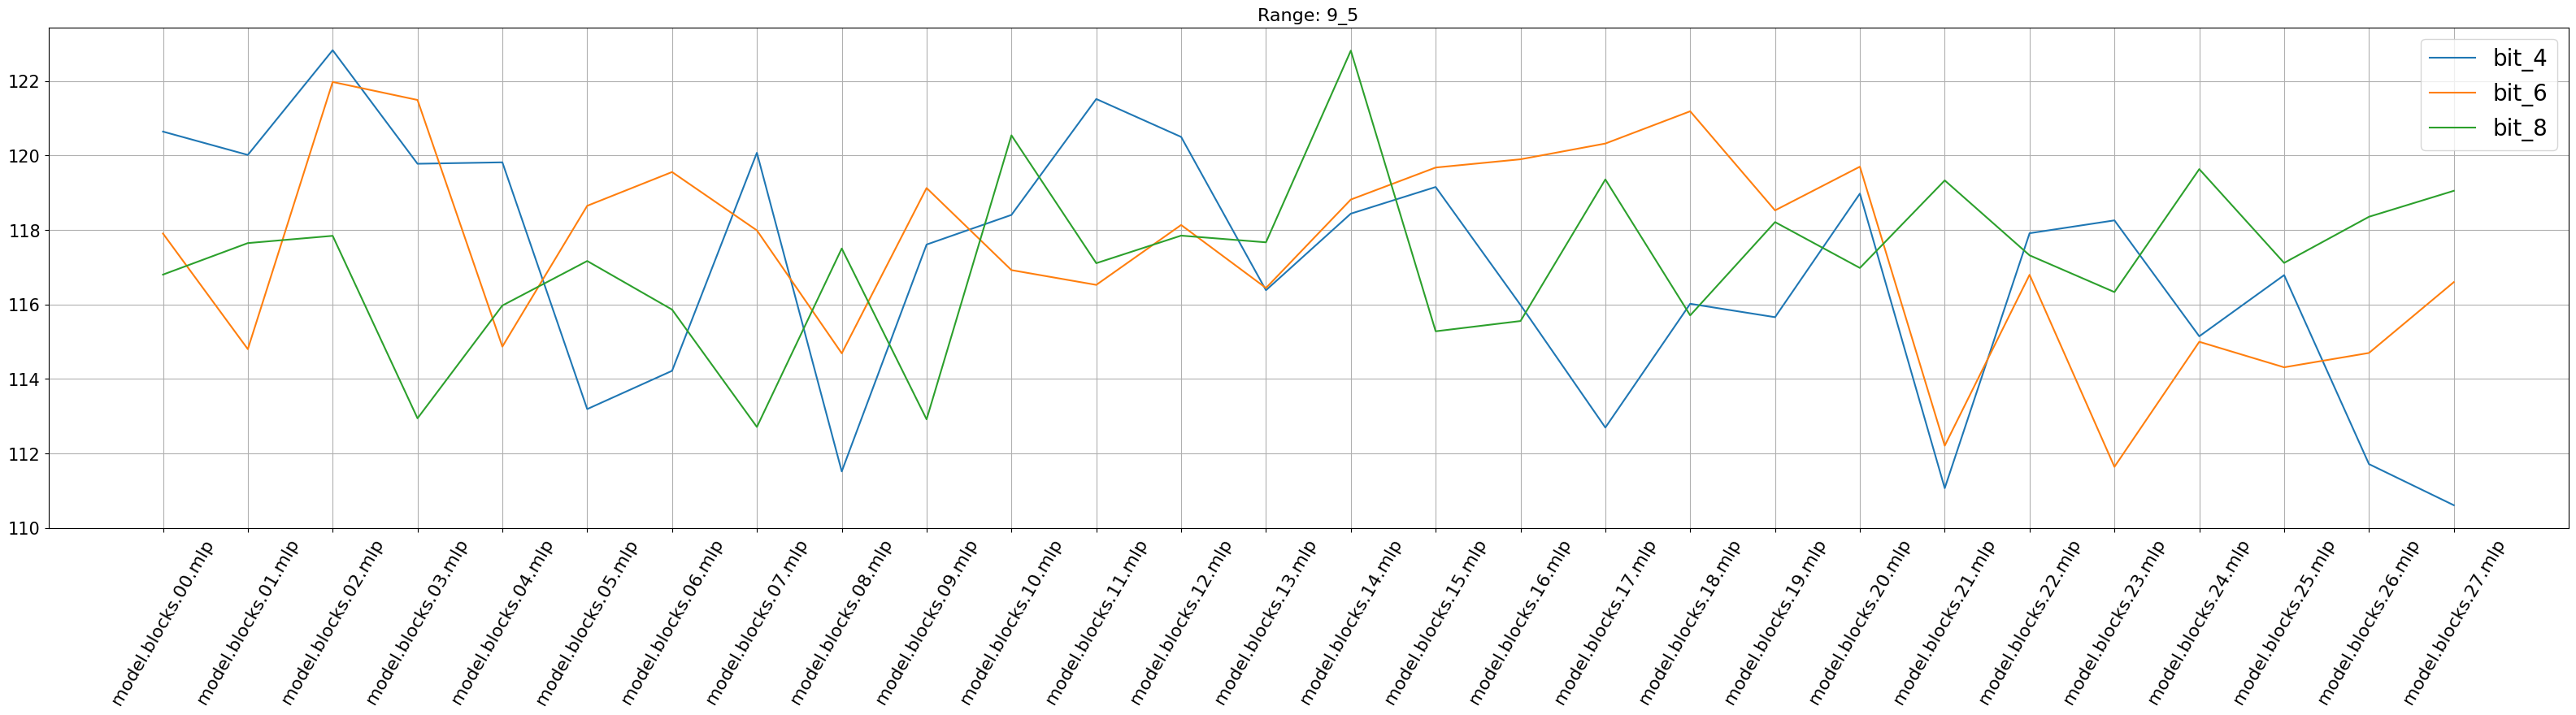

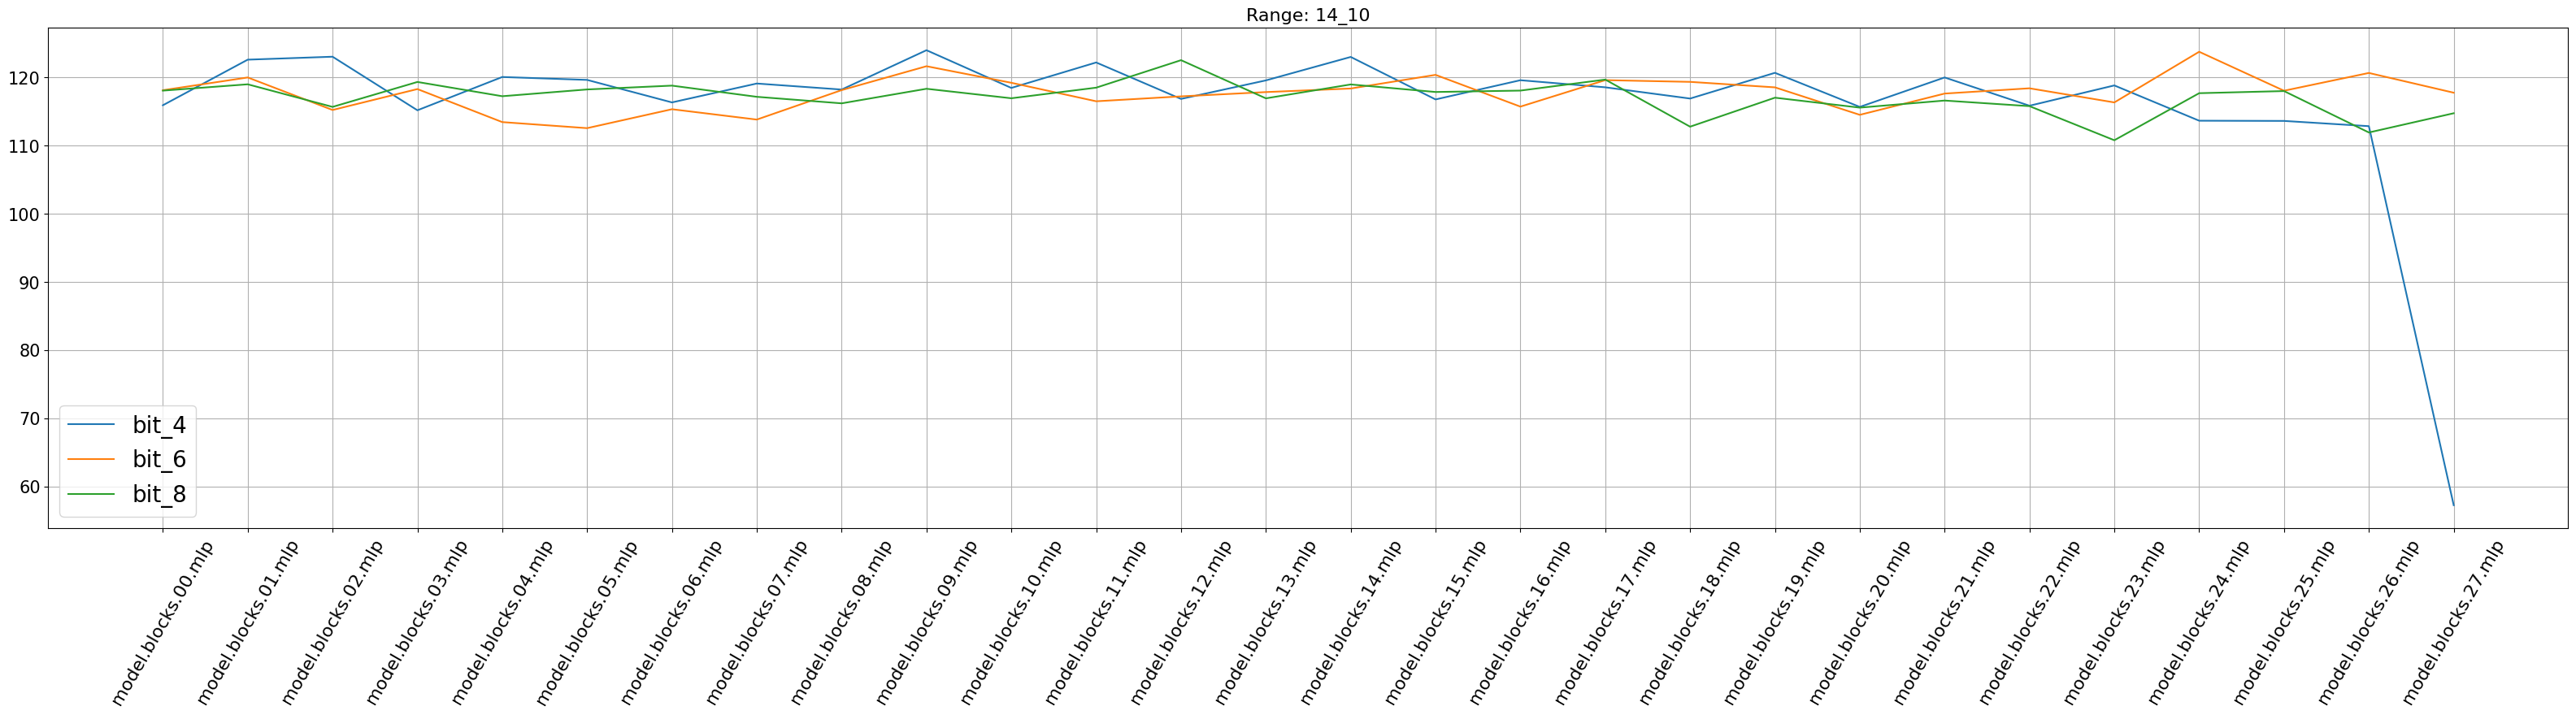

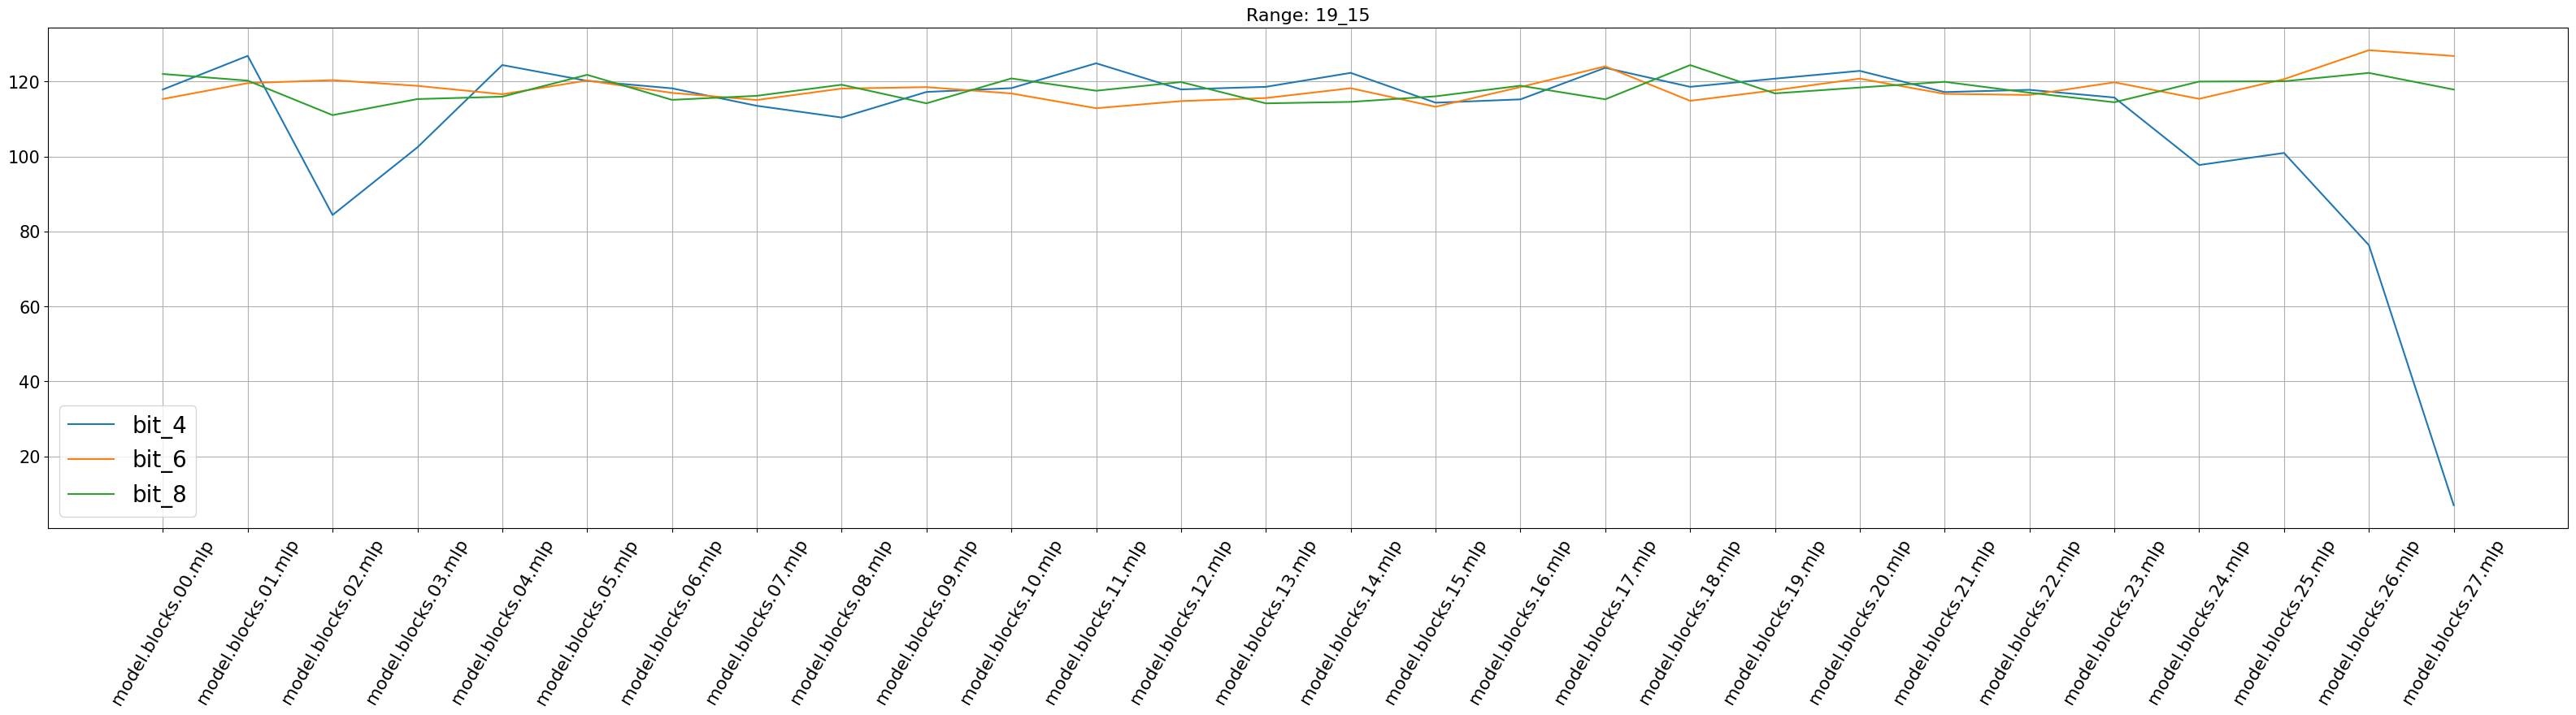

In [68]:
import matplotlib.pyplot as plt
import yaml

# 从yaml文件中加载数据
with open('/home/fangtongcheng/quant_dit/diffuser-dev/qdiff/analysis_tools/mixed_precision/sensitivity/vqa/act/mlp_act_vqa.yaml', 'r') as f:
    data = yaml.safe_load(f)

# 提取所有的block名称
blocks = list(data['14_10'].keys())

# 对于每个范围，绘制一张图
for range_name in ['4_0', '9_5', '14_10', '19_15']:
    # 创建一个新的图形
    plt.figure(figsize=(40, 8))

    # 对于每个bit值，绘制一条曲线
    for bit_index, bit_name in enumerate(['bit_4', 'bit_6', 'bit_8']):
        # 提取出这个bit值对应的所有数值
        values = [data[range_name][block][bit_index] for block in blocks]
        # 绘制曲线
        plt.plot(blocks, values, label=bit_name)

    # 添加图例
    plt.legend(fontsize=20)
    plt.xticks(rotation=60, fontsize=16)
    plt.yticks(fontsize=15)
    plt.grid()

    # 设置标题
    plt.title(f'Range: {range_name}', fontsize=16)

# 显示图形
plt.show()
